# Discrete number of transition probabilities

See Aguirregabiria & Jeon (2018), around equation (2)

$V_{b_t}(I_t)$ is the value of the firm at period $t$ given current information and beliefs.

The value of the firm is given by

$$V_{b_t}(I_t) = max_{a_t \in A} \{ \pi(a_t, x_t) + \beta 
                 \int V_{b_{t+1}}(x_{t+1}, I_t) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1}\}  $$

Probably better notation would be to write $V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t))$

the firm has a prior belief $b_0(x_1 | a_0, x_0)$ that is exogenous.
This prior is a mixuter over a collection of L transition probabilities:

$$P = \{p_l (x_{t+1} | a_t, x_t)  \}_{l=1}^L$$

so that

$$b_0(x_1 | a_0, x_0) = \sum_{l=1}^L \lambda_l^{(0)} p_l (x_1| a_0, x_0)$$

The firm observes the new state $x_t$ and uses this information to update its beliefs by using Bayes rule. The Bayesian updating is given by

$$\lambda_l^{(t)} = \frac{ p_l (x_t| a_{t-1}, x_{t-1}) \lambda_l^{(t-1)} }{      \sum_{l'=1}^L p_{l'} (x_t| a_{t-1}, x_{t-1}) \lambda_{l'}^{(t-1)}} $$

In words, $p_l (x_t| a_{t-1}, x_{t-1})$ is the probability that the $l$ transition probability gave to $x_t$ actually happening. If the probability of $x_t$ (the state that actually occured) is high under $l$, then that $l$ transition probability will get a higher weight in the beliefs of next period.

## How do the lambdas imply probabilities for the unkwnown coefficients?

A choice of $\lambda$ vector will give me one belief function

$$b_t(x_{t+1} | a_t, x_t)$$

In the demand example, $\log D_t = \alpha + \beta \log p_t +  \varepsilon_t$ is the observable, so I'll get

$$P(\alpha + \beta \log p_t +  \varepsilon_t | p_{t-1}, D_{t-1})$$

Where we assume $\alpha$ is a constant, but $\beta$ is unknown.

If $\varepsilon_t$ follows a $N(0, \sigma^2_\epsilon)$, then

$$P(\alpha + \beta \log p_t +  \varepsilon_t ) = N(\alpha + \beta \log p_t,  \sigma^2_\epsilon)$$

Then each transition probability could be a normal with a given $\beta $.
The variance of the process would be given just by the spread of $\lambda $!

Does this mean that the right $\beta$ should appear in one of the original transition probabilities?
Not sure, but I think so...and that's bad news, since it involves having many $\lambda $s

## How does the integration step look like?

It might make sense to discretize the state to make this integration easier!

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1}\}$$


I choose some collocation points for $x_{t+1}$ from $1$ to $C$ such that the above turns into 

$$\sum_{i=1}^C V_{b_{t+1}}(\lambda(x_{i, t+1})) b_t(x_{i, t+1}| a_t, I_t ) \; w_i$$

The nice thing is that the integral is only one dimensional!
The integration limits aren't super clear. From 0 to what...?

The `int_w_B` function uses Gauss-Hermite:

```python
int_w_B(self, w_guess, b, sigma_b, p, points, weights):
        """
        Integrates w_B over beta and epsilon.
        Uses Gauss-Hermite quadrature from quant-econ package

        Inputs
        -----
        points, weights = evaluation points & weights from Gauss-Hermite
        n_nodes : number of nodes for each dimension of integration (beta and epsilon)

        Returns a scalar for H(p, theta)
        """
```



In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate



def belief(new_state, transition_fs, lambda_weights, action, old_state):
    """
    state: point in state space
    transition_fs: list of transition probabilities
    """
    return np.dot(transition_fs(new_state, action, old_state), lambda_weights)

def update_lambdas(new_state, transition_fs, old_lambdas, action, old_state):
    """
    Update the beliefs for new lambdas given a new state.
    Transition_fs are fixed and exogenous
    """
    denominator = np.dot(transition_fs(new_state, action, old_state), old_lambdas) 
    return transition_fs(new_state, action, old_state)*old_lambdas / denominator



    
#b0(x_1|a0, x0) está dado. x0 está dado
#a0 = g(I_0, b_0). a0 se toma en base a b0!
#luego b_1 = h(x_2 | a_1, I_1) que da lugar a a_1 = g(I_1, b_1)
def iterate_beliefs(transition_fs, lambdas0, action0, state0, opt_action_f, t,
                   true_transition):
    """
    Simulate evolution of beliefs given lambdas0, state0
    and an optimal action function
    """
    belief_f0 = lambda state1, action0 : belief(state1, transition_fs, lambdas0,
                                            action0, state0)
    action0 = opt_action_f(belief_f0, state0)
    
    old_state = state0
    old_action = action0
    old_lambdas = lambdas0
    for _ in range(t):
        new_state = true_transition(old_action, old_state)
        new_lambdas = update_lambdas(new_state, transition_fs, old_lambdas,
                                     old_action, old_state)        
        new_belief_f = lambda new_state, action: belief(new_state, transition_fs,
                                                        new_lambdas, action, old_state)
        new_action = opt_action_f(new_belief_f, new_state)
        
        old_state = new_state
        old_action = new_action
        old_lambdas = new_lambdas
    
    return new_lambdas
    
    

## Test learning

In [27]:
# Simple test. 3 states, 4 lambdas
def transition_fs(new_state, action, old_state):
    transition1 = [0., 0.5, 0.5]
    transition2 = [0.1, 0.6, 0.3] #True one
    transition3 = [0.3, 0.7, 0.]
    transition4 = [0.3, 0.3, 0.4]
    return np.array([transition1[new_state], transition2[new_state],
                   transition3[new_state], transition4[new_state]])

def real_transition(action, old_state):
    return np.random.choice([0, 1, 2], p=[0.1, 0.6, 0.3])


lambda0 = np.array([0.1, 0.1, 0.1, 0.7])

def opt_action_f_example(current_beliefs, current_state):
    """
    Maximizes action given current_beliefs.
    Current beliefs already carry old_state and current lambda_weights
    """
    return 0

last_lambda = iterate_beliefs(transition_fs, lambda0, action0=2, state0=1, opt_action_f=opt_action_f_example, t=150,
                   true_transition=real_transition)

print(last_lambda)
assert np.allclose(last_lambda, [0, 1, 0, 0]) #True one is the second one





[0.00000000e+00 1.00000000e+00 0.00000000e+00 6.18924719e-11]


## VF iteration

In [66]:
# I think that the VF is just a function of the lambdas, so it's a function of an L-dimensional state space
# This L points live in a simplex (sum up to 1). Weird grid
# How do I define a starting VF? Needs to have a value for each point in the simplex 
# Easiest: for each point, take x_ave = E[X | lambda1=0.1, lambda2=0.3, etc] and then obtain
#          optimal action for that x_ave

# State is the observed demand. No AR process
# log(d) = α +βlog(p) +  ϵ
def true_log_demand(p, β=-2.5, α=1.0, σ_ϵ=0.5):
    return α +β*np.log(p) + np.random.normal(loc=0, scale=σ_ϵ)

max_iter = 10
iterate = 0
error = error_tol + 1
    while iterate < max_iter and error > error_tol:
        
        

dmd transition example output:  [0.0014655  0.00315619 0.0064672 ]


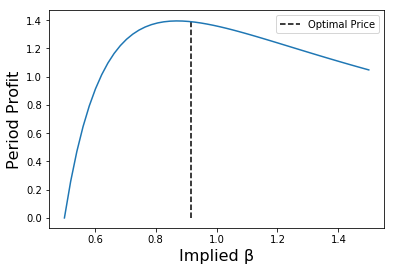

In [17]:
#three transition functions. 
from math import log
betas_transition = [-3.0, -2.5, -2.0]
σ_ɛ = 0.5
α = 1.0
c = 0.5
from scipy.stats import norm
def dmd_transition_fs(new_state, action, old_state):
    """
    Give the probability of observation a given log demand
    Action is the price
    """
    return np.array([norm.pdf(new_state, loc=(α + beta*log(action)), scale=σ_ɛ)  for beta in betas_transition  ])

print("dmd transition example output: ", dmd_transition_fs(log(0.9), 0.8, log(5.2)))

def exp_b_from_lambdas(lambdas, betas_transition=betas_transition):
    """
    Get E[β] from the lambdas
    """
    return np.dot(lambdas, betas_transition)


def myopic_price(lambdas):
    """
    Given a lambda point, spits out optimal myopic price 
    """
    #get elasticity implied by lambdas here
    elasticity = -2.2
    return c / (1 + (1/elasticity))

def period_profit(p, lambdas, betas_transition=betas_transition):
    """
    Not very kosher, since expected value doesn't make epsilon go away
    """
    E_β = exp_b_from_lambdas(lambdas, betas_transition)
    logq = α + E_β*np.log(p)
    return (p-c)*np.e**(logq)


price_options = np.linspace(0.5, 1.5, num=50)
#Optimum should be between 0.90816327 and 0.92857143

lambda0 = [0.2, 0.3, 0.5]
optimal_price = myopic_price(lambdas=lambda0)
price_options = np.linspace(0.5, 1.5, num=50)
profits = period_profit(p=price_options, lambdas=lambda0)
#initial V: just return function


fig, ax = plt.subplots(1, 1)
ax.plot(price_options, profits)
ax.vlines(optimal_price, 0, 1.4, linestyles='dashed', label="Optimal Price")
ax.set_xlabel("Implied β", size=16)
ax.set_ylabel("Period Profit", size=16)
ax.legend()




In [68]:
# V0 is just profit function with the myopic price
def V0(lambdas):
    optimal_price = myopic_price(lambdas)
    return period_profit(optimal_price, lambdas)

print(V0([0.3, 0.5, 0.2]))

## Integration Step
#TODO: find a faster way to integrate
#eOfV = lambda p: eOfV(wGuess, p, lambdas=lambda_weights)

def eOfV(wGuess, p, lambdas): #eOfV(wGuess, p)
    """
    Gives expected value of wGuess
    
    Sum of points on demand and weights, multiplied by V and the belief function
    """
    new_lambdas = lambda new_dmd: update_lambdas(new_dmd, transition_fs=dmd_transition_fs, 
                                                   old_lambdas=lambdas, action=p, old_state='No worries')
    new_belief = lambda new_dmd: belief(new_dmd, transition_fs=dmd_transition_fs,
                                       lambda_weights=new_lambdas(new_dmd), action=p, old_state='No worries')
    
    integrand = lambda new_dmd : wGuess(new_lambdas(new_dmd))*new_belief(new_dmd)
    return integrate.quad(integrand, 0.001, 20)
   
eOfV(V0, p=0.93, lambdas=[0.3, 0.5, 0.2])

1.4139826170911671


(1.4046911587666748, 8.170621828423874e-09)

## Test new expected profit

In [45]:
%%typecheck --ignore-missing-imports

import sys
sys.path.append("../")
import src
from src import const
import numpy as np




def period_profit(p: np.ndarray, lambdas: np.ndarray, betas_transition=const.betas_transition):
    """
    Correct expected period return profit. See ReadMe for derivation
    """
    constant_part = (p-const.c) * np.e ** const.α * np.e ** ((const.σ_ɛ ** 2) / 2)
    summation = np.dot(np.e**(const.betas_transition*np.log(p[:, np.newaxis])), lambdas)

    return constant_part*summation


def test_period_profit():
    p = np.array([1.4, 1.2])
    lambdas = np.array([0.5, 0.4, 0.1])
    
    beta_p_part = np.array([[np.e**(-3.*0.33647224), np.e**(-2.5*0.33647224), np.e**(-2*0.33647224)],
                       [np.e**(-3.*0.18232156), np.e**(-2.5*0.18232156), np.e**(-2*0.18232156)]])
    summation_part = np.array([0.36443148*lambdas[0] + 0.43120115*lambdas[1] + 0.51020408*lambdas[2],
                    0.5787037*lambdas[0] + 0.63393814*lambdas[1] + 0.69444444*lambdas[2]])
    
    expected = (p-const.c) * np.e ** const.α * np.e ** ((const.σ_ɛ ** 2) / 2) * summation_part
    
    computed = period_profit(p, lambdas)
    
    assert np.allclose(expected, computed)
    
test_period_profit()

In [35]:
np.log(p)

array([0.33647224, 0.18232156])

In [25]:
const.betas_transition

array([-3. , -2.5, -2. ])

In [27]:
expected = np.array([[-3*1.4, -2.5*1.4, -2*1.4],
                    [-3*1.2, -2.5*1.2, -2*1.2]])
expected

array([[-4.2, -3.5, -2.8],
       [-3.6, -3. , -2.4]])

In [22]:
const.betas_transition*p

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [19]:
np.e**(const.betas_transition*np.log(p))

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [70]:
lambda_weights = [0.2, 0.5, 0.3]
eOfV_p = lambda p: eOfV(V0, p, lambda_weights)
eOfV_p(0.5)

(1.6986486260010063, 3.485545147684773e-09)

In [47]:
def generate_simplex_3dims(n_per_dim=20):
    xlist = np.linspace(0.0, 1.0, n_per_dim)
    ylist = np.linspace(0.0, 1.0, n_per_dim)
    zlist = np.linspace(0.0, 1.0, n_per_dim)
    return np.array([[x, y, z] for x in xlist for y in ylist for z in zlist 
                     if np.allclose(x+y+z, 1.0)])



In [57]:
simplex3d.shape[0]

15

In [69]:

δ = 0.9
n_per_dim = 20
simplex3d = generate_simplex_3dims(n_per_dim)

def bellman_operator(wGuess):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.

    Parameters
    ----------
    w_guess : 
        Matrix on lambdas or function on lambdas 
    """
    #policy = np.empty_like(wGuess)
    #Tw = np.empty_like(wGuess)
    policy = np.empty(simplex3d.shape[0])
    Tw = np.empty(simplex3d.shape[0])
    
    #1. go over grid of state space
    #2. Write objective (present return + delta*eOfV)
    #3. Find optimal p on that objective
    #4. write optimal p and value function on that point in the grid
    for iII, (λ1, λ2, λ3) in enumerate(simplex3d):
        lambda_weights = [λ1, λ2, λ3]
        R_ = lambda p: period_profit(p, lambdas=lambda_weights)  #period_profit(p, lambdas,
        eOfV_p = lambda p: eOfV(wGuess, p, lambdas=lambda_weights)
        objective_vals = R_(price_options) + δ*eOfV_p(price_options)  
        pStar = price_options[np.argmax(objective_vals)]
        policy[iII] = pStar
        Tw[iII] = objective(pStar)
        
    return Tw, policy

Tw, policy = bellman_operator(V0)

TypeError: only size-1 arrays can be converted to Python scalars

In [23]:
np.max([3, 2, 1, 9, 3])




9

In [24]:
np.argmax([3, 2, 1, 9, 3])

3

In [48]:
def compute_fixed_point(T, v, error_tol=1e-5, max_iter=50, verbose=1,
                        skip=10, *args,
                        **kwargs):
    """
    Computes and returns :math:`T^k v`, an approximate fixed point.

    Here T is an operator, v is an initial condition and k is the number
    of iterates. Provided that T is a contraction mapping or similar,
    :math:`T^k v` will be an approximation to the fixed point.

    Parameters
    ----------
    T : callable
        A callable object (e.g., function) that acts on v.
        The bellman operator
    v : object
        An object such that T(v) is defined. Initial guess.
    error_tol : scalar(float), optional(default=1e-5)
        Error tolerance
    max_iter : scalar(int), optional(default=50)
        Maximum number of iterations
    verbose : bool, optional(default=True)
        If True then print current error at each iterate.
    args, kwargs :
        Other arguments and keyword arguments that are passed directly
        to  the function T each time it is called

    Returns
    -------
    v : object (usually array)
        The approximate fixed point
    policy : object (usually array)
        the policy at the approximate fixed point

    """
    iterate = 0
    error = error_tol + 1
    while iterate < max_iter and error > error_tol:
        start_iter = time.time()
        new_v, policy = T(v, *args, **kwargs)
        iterate += 1
        error = np.max(np.abs(new_v - v))
        if verbose and iterate%skip==0 :
            time_taken = (time.time() - start_iter) / 60.
            print("Computed iterate %d with error %f in %f minutes" % (iterate, error, time_taken))
        try:
            v[:] = new_v
        except TypeError:
            v = new_v
    return v, policy, error

array([  0.00000000e+00,   9.99999059e-01,   0.00000000e+00,
         9.40837326e-07])

In [ ]:
v_star, policy_star, error = lp.compute_fixed_point(bellman_operator, max_iter=max_iters, v=w_values,
                                                    kind='linear')

In [39]:
def bellman_operator(self, wGuess, kind='linear', compute_policy=True):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.

    Parameters
    ----------
    w_guess : array_like(float, ndim=2)
        The value of the input function on (sVal, alphaVal)
    kind : string
        Type of interpolation.
    compute_policy : Boolean, optional(default=False)
        Whether or not to compute policy function
    """

    assert wGuess.shape == self.dimsV

    # === Interpolate wGuess in two dims ====== #

    #interpW = interp1d(self.SGrid, wGuess, kind=kind, assume_sorted=True,
    #                   bounds_error=False, fill_value=wGuess[0])
    interpW = RectBivariateSpline(self.SGrid, self.alpha_grid, wGuess,
                                bbox=[min(self.SGrid) - 2, max(self.SGrid), 
                                     min(self.alpha_grid) -2 , max(self.alpha_grid)])


    policy = np.empty_like(wGuess)
    Tw = np.empty_like(wGuess)

    for iII, s in enumerate(self.SGrid):
        for jJJ, alpha in enumerate(self.alpha_grid):
            R_ = lambda p: self.RFunc(p, s, alpha)
            eOfV = lambda p: self.eOfV(interpW, p, s, alpha)
            objective = (lambda p: -(R_(p) + self.delta*eOfV(p) )  )
            minP, maxP = 1.0e-6, 15
            pStar = fminbound(objective, minP, maxP, maxfun=100, disp=1)

            Tw[iII, jJJ] = -objective(pStar)
            policy[iII, jJJ] = pStar
    if compute_policy:
        return Tw, policy
    else:
        return Tw

array([ 0.4,  0.1,  0.2,  0.3])

In [8]:
"""
Add mypy type-checking cell magic to jupyter/ipython.
Save this script to your ipython profile's startup directory.
IPython's directories can be found via `ipython locate [profile]` to find the current ipython directory and ipython profile directory, respectively.
For example, this file could exist on a path like this on mac:
/Users/yourusername/.ipython/profile_default/startup/typecheck.py
where /Users/yourusername/.ipython/profile_default/ is the ipython directory for
the default profile.
The line magic is called "typecheck" to avoid namespace conflict with the mypy
package.
"""

from IPython.core.magic import register_cell_magic


@register_cell_magic
def typecheck(line, cell):
    """
    Run the following cell though mypy.
    Any parameters that would normally be passed to the mypy cli
    can be passed on the first line, with the exception of the
    -c flag we use to pass the code from the cell we want to execute
     i.e.
    %%typecheck --ignore-missing-imports
    ...
    ...
    ...
    mypy stdout and stderr will print prior to output of cell. If there are no conflicts,
    nothing will be printed by mypy.
    """

    from IPython import get_ipython
    from mypy import api

    # inserting a newline at the beginning of the cell
    # ensures mypy's output matches the the line
    # numbers in jupyter

    cell = '\n' + cell

    mypy_result = api.run(['-c', cell] + line.split())

    if mypy_result[0]:  # print mypy stdout
        print(mypy_result[0])

    if mypy_result[1]:  # print mypy stderr
        print(mypy_result[1])

    shell = get_ipython()
    shell.run_cell(cell)

## Problem: Interpolate 1D array over simplex to a function

In [76]:
import sys
sys.path.append("../")
import src

In [108]:
simplex_points[:, 0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.22222222,
       0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222, 0.22222222, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.44444444,
       0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444,
       0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.77777778,
       0.77777778, 0.77777778, 0.88888889, 0.88888889, 1.        ])

In [131]:
def approx_this_f(x, y, z):
    return 2*x - y + 5*z

def approx_this_f_vec(array):
    res = np.empty(len(array))
    for row in range(len(array)):
        res[row] = approx_this_f(*array[row])
    return res
        

simplex_points = src.generate_simplex_3dims(10)

values = np.empty(len(simplex_points))
for i, lambda_0 in enumerate(simplex_points):
    values[i] = approx_this_f(lambda_0[0], lambda_0[1],
                         lambda_0[2])
    
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import Rbf
x, y, z = simplex_points[:, 0], simplex_points[:, 1], simplex_points[:, 2]
interpolated_f = Rbf(x, y, z, values)
#interpolated_f = LinearNDInterpolator(simplex_points, values, )

In [149]:
lambdas_except_last = np.array([0., 0.])
full_lambdas = np.array(list(lambdas_except_last) + [1 - lambdas_except_last.sum()])
full_lambdas

array([0., 0., 1.])

In [146]:
lambdas_except_last = np.array([0.5, 0.4, 0.1])
lambdas = np.array(lambdas_except_last + [1 - lambdas_except_last.sum()])
lambdas

array([0.5, 0.4, 0.1])

In [139]:
interpolated_f2 = LinearNDInterpolator(simplex_points[:, 0:2], values)
points_test = src.generate_simplex_3dims(50)
print(len(points_test))
two_points = np.array([[0.4, 0.3, 0.3], [0., 0., 1.]])
interpolated_vals = interpolated_f2(points_test[:, 0:2])
real_values = approx_this_f_vec(points_test)

(interpolated_vals - real_values).max()

1275


1.7763568394002505e-15

1.7763568394002505e-15

In [110]:
interpolated_f(0.4, 0.3, 0.3)

array(1.99985478)

In [101]:
from scipy.interpolate import griddata
#points=  #(n, D)
#values = (n,)
#xi :(M, D)
xi = src.generate_simplex_3dims(20)
avers = griddata(simplex, values, xi,
     method='nearest')


In [89]:
src.generate_simplex_3dims(4).shape

(10, 3)

In [78]:
simplex

array([[0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0.5, 0. , 0.5],
       [0.5, 0.5, 0. ],
       [1. , 0. , 0. ]])

In [21]:
np.dot(transition_fs(new_state, action, old_state), old_lambdas)

array([  8.77342977e-08,   4.49199604e-05,   5.18062255e-03,
         1.37994118e-01,   8.56780251e-01])

In [14]:
new_state = 4
denominator = np.dot(transition_fs(new_state), old_lambdas) 


In [16]:
transition_fs(new_state)*old_lambdas / denominator

TypeError: can't multiply sequence by non-int of type 'list'

In [19]:
transition_fs(new_state)*old_lambdas

TypeError: can't multiply sequence by non-int of type 'list'

[0.2, 0.1, 0.2, 0.3, 0.2]